In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"

import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2

In [5]:
import analyze_utils

# this model was trained on too-easy data: single hard negatives generated from a broken t5.
# checkpoint_folder = "/home/jxm3/research/retrieval/inversion/saves/ef674b4d1bdb4d5d5d678e8ef1aafe98/"
# this is the next model we trained using 4x as many better negatives, but only for an hour.
checkpoint_folder = "/home/jxm3/research/retrieval/inversion/saves/707b21d92c5d4c3678d3872e68ea1383/"

trainer = analyze_utils.load_trainer(checkpoint_folder)

Loading trainer for analysis – setting --do_eval=1
loading alias dpr_nq__msl32_beta from /home/jxm3/research/retrieval/inversion/saves/db66b9c01b644541fedbdcc59c53a285/ebb31d91810c4b62d2b55b5382e8c7ea...
Set train_args.dataloader_num_workers = 4


/home/jxm3/.conda/envs/torch/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


================ Begin trainer sanity check ================
	Input to encode -> Twas brillig, and the slithy toves, Did gyre and gimble in the wabe, All mimsy were the borogoves, And the mome raths outgrabe.
	Decoded output -> <pad> The m<unk>lbies wase wyst bograge; And the sliths and toms wy</s>
================ End trainer sanity check ================


In [6]:
trainer.args.per_device_eval_batch_size = 64
eval_batch = next(iter(trainer.get_eval_dataloader()))
# eval_batch = {k: v[0:1, ...] for k,v in eval_batch.items()} # just one guy
eval_batch = {k: v.to(trainer.args.device) for k,v in eval_batch.items()}

In [34]:
import torch
with torch.no_grad():
    reranked_gens = trainer.generate_with_reranking(eval_batch, L=5, B=4)

> /home/jxm3/research/retrieval/inversion/trainers.py(513)generate_with_reranking()
    511             scores = torch.einsum("bwd,bd->bw", hypothesis_embeddings, embedding_embeds)
    512             import pdb; pdb.set_trace()
--> 513             assert scores.shape == (batch_size, B)
    514             # truncate beams
    515             hypotheses = hypotheses.reshape((batch_size, B, hypothesis_length))



ipdb>  p scores


tensor([[0.3820, 0.3021, 0.3177, 0.3128],
        [0.2872, 0.3569, 0.4901, 0.2289],
        [0.3377, 0.4095, 0.3195, 0.4247],
        [0.4271, 0.3566, 0.3771, 0.3400],
        [0.4910, 0.3855, 0.4682, 0.2483],
        [0.3806, 0.3881, 0.3967, 0.3893],
        [0.3701, 0.3984, 0.3808, 0.4155],
        [0.2644, 0.2351, 0.2430, 0.2439],
        [0.2939, 0.1258, 0.2239, 0.2122],
        [0.2432, 0.3396, 0.3810, 0.3566],
        [0.2777, 0.2980, 0.2861, 0.2291],
        [0.3212, 0.4001, 0.4353, 0.3126],
        [0.2993, 0.2942, 0.2695, 0.2304],
        [0.4257, 0.4265, 0.4272, 0.3877],
        [0.3748, 0.4363, 0.4427, 0.4183],
        [0.4966, 0.5322, 0.5392, 0.4933],
        [0.4602, 0.5039, 0.3837, 0.4900],
        [0.3673, 0.4007, 0.3963, 0.4266],
        [0.1864, 0.3783, 0.1979, 0.1712],
        [0.4297, 0.4547, 0.4379, 0.4504],
        [0.1476, 0.1816, 0.0501, 0.2265],
        [0.4145, 0.3557, 0.4332, 0.4014],
        [0.4014, 0.3441, 0.3906, 0.3794],
        [0.3262, 0.3764, 0.3966, 0

ipdb>  exit


In [8]:
gens = trainer.inversion_trainer.model.generate(eval_batch, generation_kwargs={
    "num_beams": 4,
    "num_return_sequences": 1,
    "do_sample": False,
    "no_repeat_ngram_size": 3,
})[:, 1:]

In [9]:
reranked_gens.shape, gens.shape

(torch.Size([64, 32]), torch.Size([64, 32]))

In [10]:
trainer.embedder_tokenizer.batch_decode(gens[0:1])

['to that of the skulls of infant sutures, which are relatively smooth and untidy in character. Nevertheless, the suture </s>']

In [11]:
trainer.embedder_tokenizer.batch_decode(reranked_gens[0:1])

['to the character of the skull, which are relatively smooth and untutuous in the manner of infant sutures. Indeed, the skull of one</s>']

In [12]:
gens_text = trainer.embedder_tokenizer.batch_decode(gens, add_special_tokens=False)
reranked_text = trainer.embedder_tokenizer.batch_decode(reranked_gens, add_special_tokens=False)
true_text = trainer.embedder_tokenizer.batch_decode(eval_batch['embedder_input_ids'])

In [13]:
bleu = trainer.inversion_trainer.metric_bleu

In [42]:
bleu.compute(
    predictions=gens_text, references=true_text
)

{'score': 35.64198521987842,
 'counts': [1296, 765, 481, 305],
 'totals': [1814, 1750, 1686, 1622],
 'precisions': [71.44432194046307,
  43.714285714285715,
  28.52906287069988,
  18.803945745992603],
 'bp': 0.990672221585101,
 'sys_len': 1814,
 'ref_len': 1831}

In [15]:
bleu.compute(
    predictions=reranked_text, references=true_text
)

{'score': 29.745891218688616,
 'counts': [1250, 675, 398, 212],
 'totals': [1834, 1770, 1706, 1642],
 'precisions': [68.15703380588877,
  38.13559322033898,
  23.329425556858148,
  12.911084043848964],
 'bp': 1.0,
 'sys_len': 1834,
 'ref_len': 1831}

## hparam search


In [ ]:
import torch

data = []
for L in [1, 4, 8, 16]:
    print(f"L={L}")
    for B in [1, 4, 8, 16]:
        with torch.no_grad():
            reranked_gens = trainer.generate_with_reranking(eval_batch, L=L, B=B)
        reranked_text = trainer.embedder_tokenizer.batch_decode(reranked_gens, add_special_tokens=False)
        bleu_score = bleu.compute(predictions=reranked_text, references=true_text)
        data.append((L, B, bleu_score["score"]))

L=1
L=4
L=8
L=16


<Axes: xlabel='B', ylabel='L'>

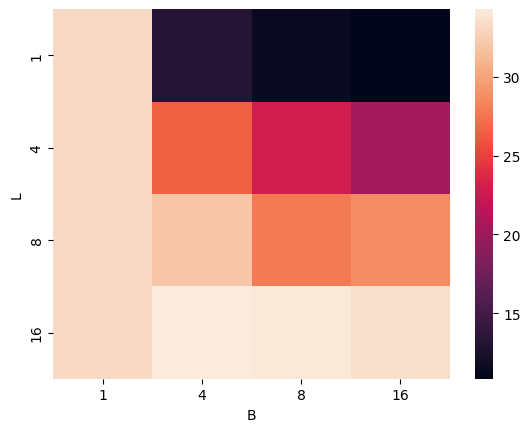

In [40]:
import pandas as pd

df = pd.DataFrame(data, columns=["L", "B", "bleu_score"])

import seaborn as sns
sns.heatmap(df.pivot(index='L', columns='B', values='bleu_score'))

In [41]:
df.max()

L             16.000000
B             16.000000
bleu_score    34.302609
dtype: float64

## looking at generations

In [16]:
true_ids = eval_batch['embedder_input_ids']
(true_ids[:, 0] == gens[:, 0]).float().mean()

tensor(0.6719, device='cuda:0')

In [17]:
(true_ids[:, 0] == reranked_gens[:, 0]).float().mean()

tensor(1., device='cuda:0')

In [18]:
import pandas as pd

df = pd.DataFrame(zip(true_text, gens_text, reranked_text), columns=['true', 'generated', 'generated w/ reranking'])

In [19]:
df

,true,generated,generated w/ reranking
0,to the character of the sutures of the skull w...,"to that of the skulls of infant sutures, which...","to the character of the skull, which are relat..."
1,"individual from the Southern Hemisphere, to wi...",individual from the Southern Hemisphere to win...,individual from Australia to win the Winter Ol...
2,"the same rights as straight people, while 15% ...","the same rights as heterosexuals, and 75% agre...","the same rights as straight people, and 37% ag..."
3,"Bruthen, Victoria Bruthen is a small town loca...","Bruthen, Victoria Brutten is a small town loca...","Bruthen, Victoria Brutheen is a small town sit..."
4,Castle Vale Castle Vale is a housing estate lo...,Castle Vale castle Vale is a castle located be...,Castle Vale castle Vale is a place located bet...
...,...,...,...
59,"of the largely unsuccessful ""90 Bristol Court""...","largely unsuccessful ""Bampton Court"" for the r...",of the largely unsuccessful '84 Court'. The fi...
60,The band was most popular in the 1990s in Japa...,The band's most popular album was released in ...,"The band was most popular in Japan, where thei..."
61,that to successfully affect the youth it has t...,that it can incorporate events beyond its crea...,that it incorporates events beyond its creatio...
62,at Advision. Cordell was concerned that the so...,radio. Talbotton was concerned that the sound ...,at the radio station. White of the Shade of Pa...
